## 🏠 House Prices - XGBoost

### Destaques do Modelo XGBoost 

* **Pré-processamento inicial:** leitura dos dados e remoção de colunas com mais de 10% de valores ausentes, garantindo um conjunto de treino consistente e sem variáveis excessivamente incompletas.

* **Transformação das variáveis:** aplicação de imputação por mediana e padronização nas variáveis numéricas, enquanto as categóricas são convertidas via One-Hot Encoding. Todo o fluxo é integrado em um único ColumnTransformer para assegurar coerência durante treino e inferência.

* **Treinamento do modelo:** construção de um pipeline com o XGBRegressor. O modelo é treinado utilizando a variável alvo em escala logarítmica para maior estabilidade e desempenho preditivo.


## 1. Bibliotecas


In [1]:
# =====================================================
# 🏠 House Prices - XGBoost
# =====================================================
import pandas as pd

# XGBoost
from xgboost import XGBRegressor
from setup_notebook import setup_path
setup_path()
from src.model_utils import *
import joblib
import matplotlib.pyplot as plt
from pathlib import Path

import warnings

warnings.filterwarnings("ignore")

## 2. Dataload & preprocessamento

In [2]:
BASE = Path.cwd().parent   
# =====================================================
# ⚙️ 0. carregamento dos preprocessador 
# =====================================================
temp = joblib.load(BASE /'src'/'preprocess_house_prices_v1.joblib')
preprocessador=temp['preprocessador']
colnull_train = temp['colnull_train']

# =====================================================
# 📁 1. Leitura dos dados & Separação das bases
# =====================================================

DATA_DIR = BASE / "data" / "processed"
X_train = pd.read_csv(DATA_DIR / "X_train_final.csv")
X_test  = pd.read_csv(DATA_DIR / "X_test_final.csv")
y_train = pd.read_csv(DATA_DIR / "y_train_final.csv")
y_test  = pd.read_csv(DATA_DIR / "y_test_final.csv")

# =====================================================
#  🤖 4.Modelos
# =====================================================
model_xg0    = XGBRegressor( objective='reg:squarederror',random_state=42,n_jobs=-1 ) 
XGB0         = pipe_models(model_xg0 , preprocessador)

model_xg1    = XGBRegressor( objective='reg:squarederror', n_estimators=1000,
                         subsample= 0.8,max_depth= 6,learning_rate= 0.1,
                         colsample_bytree= 0.8,random_state=42,n_jobs=-1 ) 
XGB1         = pipe_models(model_xg1 , preprocessador)

model_xg2    = XGBRegressor( objective='reg:squarederror', n_estimators=700,
                         subsample= 0.6,reg_lambda= 0.5,reg_alpha= 1.0,
                         max_depth= 3,learning_rate= 0.073,
                         colsample_bytree= 0.7,
                         n_jobs=-1 ) 
XGB2         = pipe_models(model_xg2 , preprocessador)

## 3.Treinamento
### 3.1 XGB0

In [3]:
# 1. Valida a estabilidade 
r20 = valida(X_train, y_train, model=XGB0, N=7)

# 2. Testa a performance 
XGB0.fit(X_train, y_train)
y_pred = XGB0.predict(X_test)
res0 = metricas_model(y_test, y_pred, 'XGBoost 0')

Validação cruzada realizada!


### 3.2 XGB1

In [4]:
# 1. Valida a estabilidade 
r21 = valida(X_train, y_train, model=XGB1, N=7)

# 2. Testa a performance 
XGB1.fit(X_train, y_train)
y_pred = XGB1.predict(X_test)
res1 = metricas_model(y_test, y_pred, 'XGBoost 1')

Validação cruzada realizada!


### 3.3 XGB2

In [6]:
# 1. Valida a estabilidade 
r22 = valida(X_train, y_train, model=XGB2, N=7,write='on')

# 2. Testa a performance 
XGB2.fit(X_train, y_train)
y_pred = XGB2.predict(X_test)
res2 = metricas_model(y_test, y_pred, 'XGBoost 2','on')

validação cruzada (K-Fold Cross Validation)
Fold 1: R² = 0.8880
Fold 2: R² = 0.9171
Fold 3: R² = 0.9060
Fold 4: R² = 0.8487
Fold 5: R² = 0.9081
Fold 6: R² = 0.8655
Fold 7: R² = 0.8778

📊 R² médio: 0.8873 ± 0.0231
🤖 XGBOOST 2
MAE:   0.0838
RMSE:  0.124
R²:   0.9093


---

,Modelo,MAE,RMSE,R²
0,XGBoost 0,0.0976,0.145,0.8760
1,XGBoost 1,0.0894,0.132,0.8973
2,XGBoost 2,0.0838,0.124,0.9093


,Modelo,R2_Médio,R2_Std
0,XGB0,0.858216,0.020770
1,XGB1,0.884859,0.021943
2,XGB2,0.887314,0.023056


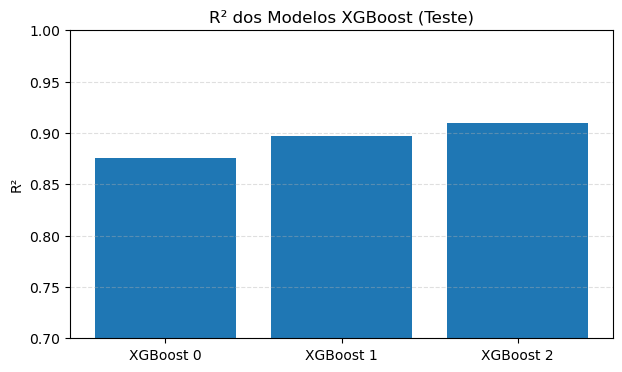

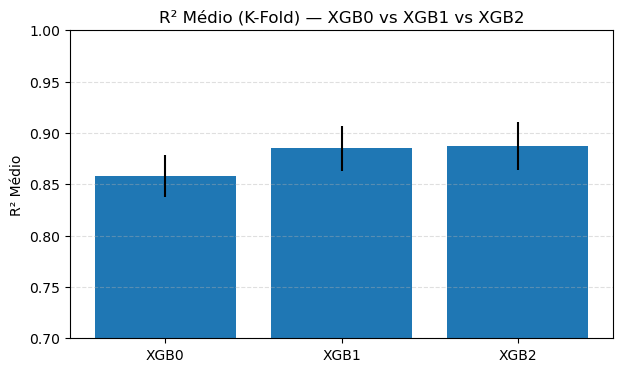

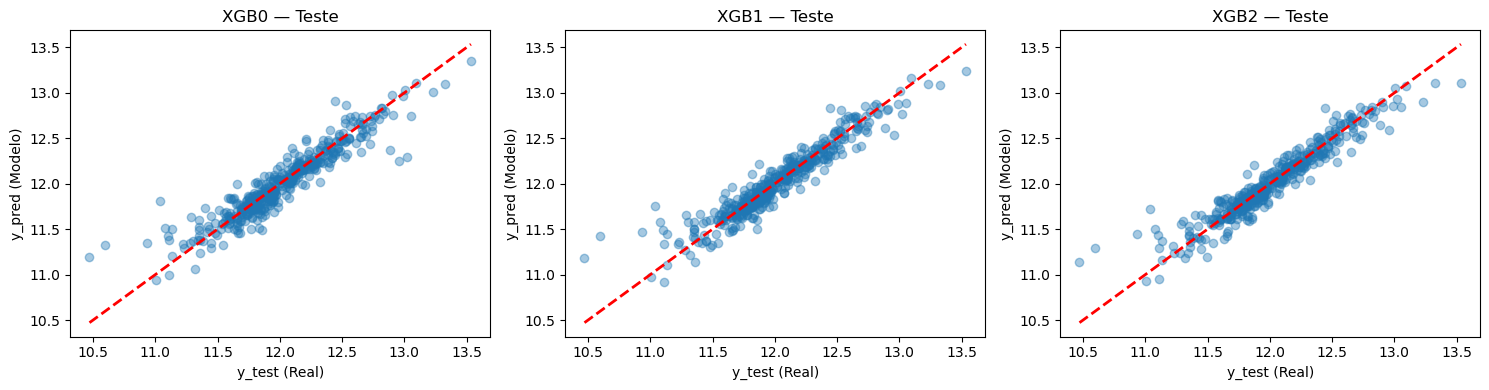

In [7]:
# =====================================================
# 1. Organizar resultados em DataFrame
# =====================================================

resultados_teste = pd.DataFrame([
    res0, res1, res2
])

resultados_cv = pd.DataFrame({
    "Modelo": ["XGB0", "XGB1", "XGB2"],
    "R2_Médio": [np.mean(r20), np.mean(r21), np.mean(r22)],
    "R2_Std":   [np.std(r20),  np.std(r21),  np.std(r22)]
})

display(resultados_teste)
display(resultados_cv)

# =====================================================
# 2. Gráfico — R² no conjunto de teste
# =====================================================

plt.figure(figsize=(7,4))
plt.bar(resultados_teste['Modelo'], resultados_teste['R²'])
plt.title("R² dos Modelos XGBoost (Teste)")
plt.ylabel("R²")
plt.ylim(0.7, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()

# =====================================================
# 3. Gráfico — R² médio da validação cruzada
# =====================================================

plt.figure(figsize=(7,4))
plt.bar(resultados_cv['Modelo'], resultados_cv['R2_Médio'], yerr=resultados_cv['R2_Std'])
plt.title("R² Médio (K-Fold) — XGB0 vs XGB1 vs XGB2")
plt.ylabel("R² Médio")
plt.ylim(0.7, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()

# =====================================================
# 4. Gráfico de Dispersão — y_test vs y_pred para cada modelo
# =====================================================

predicoes = {
    "XGB0": XGB0.predict(X_test),
    "XGB1": XGB1.predict(X_test),
    "XGB2": XGB2.predict(X_test)
}

plt.figure(figsize=(15,4))

for i, (nome, y_p) in enumerate(predicoes.items(), 1):
    plt.subplot(1, 3, i)
    plt.scatter(y_test, y_p, alpha=0.4)
    plt.plot([y_test.min(), y_test.max()],
             [y_test.min(), y_test.max()],
             'r--', linewidth=2)
    plt.title(f"{nome} — Teste")
    plt.xlabel("y_test (Real)")
    plt.ylabel("y_pred (Modelo)")

plt.tight_layout()
plt.show()

## Considerações finais

## Sintese Dos resultados 

* Observa-se um ganho progressivo e consistente: RMSE: 0.145 → 0.132 → 0.124 e R²: 0.876 → 0.897 → 0.909
* A redução simultânea de MAE e RMSE indica:melhora tanto em erros médios quanto em grandes desvios e modelo mais confiável globalmente.

### Estabilidade (validação cruzada)

* Os três modelos apresentam **baixo desvio padrão do R²** (≈ 0.02), indicando:

  * alta estabilidade;
  * baixa sensibilidade à partição dos dados.
* O XGB2 apresenta o maior R² médio, confirmando sua robustez.

Os resultados demonstram que o XGBoost é o modelo mais eficaz para este problema, combinando **capacidade de modelagem não linear**, **regularização explícita** e **excelente generalização**.

### Conclusões práticas

* **XGB2** é o modelo recomendado:

  * melhor desempenho preditivo;
  * alta estabilidade;
  * controle eficiente de *overfitting*.
* O ganho em relação ao Random Forest confirma a vantagem do **boosting sequencial** sobre ensembles independentes.
* Apesar do maior custo computacional, o ganho de performance justifica seu uso em cenários de produção e competição.